<a href="https://colab.research.google.com/github/dsguseong/Mystudy/blob/dsguseong-patch-1/section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 각 프로젝트마다 여러 특성들에 의하여 투자금을 유치할 수 있을지 없을지에 관한 데이터입니다. (프로젝트 지원 투자금 승인여부)

이 데이터는 프로젝트에 투자금을 지원할 때, 어떤 프로젝트가 어떠한 이유들에 의하여 투자를 승인 받을 수 있는지, 혹은 없는지를 여러가지 이유에 의하여 분석해보고 차후에 어떠한 프로젝트가 승인받을 수 있을지 없을지를 예측해보고자 선정되었습니다.\

시나리오 : 우리기관의 투자금을 받기 위하여, 사람들이 각자가 가지고 있는 프로젝트마다 투자금을 유치하고자 합니다. 우리기관에서 투자를 승인한 프로젝트마다 어떠한 특성들에 관련하여 투자금을 승인하였는지를 알아보고, 앞으로 어떤 특성들의 데이터를 가진 프로젝트가 투자금 유치를 성공적으로 승인받을 수 있을지에 대하여 알아보고, 앞으로 이러한 분석결과를 기반으로하여 투자금 승인여부를 빠르며 객관적으로 예측할 수 있는 모델을 만들어 투자금 승인 여부를 결정하고자 합니다.

##프로젝트. 섹션2 (시작 전 라이브러리 및 함수 불러오기)

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [2]:
!pip install eli5
!pip install -U scikit-learn
from pandas_profiling import ProfileReport
from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
from category_encoders import OrdinalEncoder

from sklearn.pipeline import Pipeline #make_pipeline과의 차이를 알아둘 것
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OrdinalEncoder #float type을 제외한 다른 타입 전부 변환 *사용주의*
from sklearn.feature_selection import f_regression, SelectKBest
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report

import eli5
from eli5.sklearn import PermutationImportance

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import matplotlib.font_manager
import matplotlib.pyplot as plt
from pdpbox import pdp
import seaborn as sns
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore') # (참고) warning 제거를 위한 코드


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#데이터 전처리 (Data Preprocessing)

In [5]:
train_url = '/content/train.csv'


# train 데이터셋을 불러옵니다
df = pd.read_csv(train_url)


Variable Description (데이터의 특성 설명)

project_id: unique id of project

name: name of the project

desc: description of project

goal: the goal (amount) required for the project

keywords: keywords which describe project

disable communication: whether the project authors has disabled communication option with people donating to the project

country: country of project author

currency: currency in which goal (amount) is required

deadline: till this date the goal must be achieved (in unix timeformat)

statechangedat: at this time the project status changed. Status could be successful, failed, suspended, cancelled etc. (in unix timeformat)

created_at: at this time the project was posted on the website(in unix timeformat)

launched_at: at this time the project went live on the website(in unix timeformat)

backers_count: number of people who backed the project

final_status: whether the project got successfully funded (target variable – 1,0)

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108129 entries, 0 to 108128
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   project_id             108129 non-null  object 
 1   name                   108126 non-null  object 
 2   desc                   108120 non-null  object 
 3   goal                   108129 non-null  float64
 4   keywords               108129 non-null  object 
 5   disable_communication  108129 non-null  bool   
 6   country                108129 non-null  object 
 7   currency               108129 non-null  object 
 8   deadline               108129 non-null  int64  
 9   state_changed_at       108129 non-null  int64  
 10  created_at             108129 non-null  int64  
 11  launched_at            108129 non-null  int64  
 12  backers_count          108129 non-null  int64  
 13  final_status           108129 non-null  int64  
dtypes: bool(1), float64(1), int64(6), ob

In [7]:
df.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,1241333999,1241334017,1240600507,1240602723,3,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,1242429000,1242432018,1240960224,1240975592,2,0
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,False,US,USD,1243027560,1243027818,1242163613,1242164398,0,0
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0,help-me-write-my-second-novel,False,US,USD,1243555740,1243556121,1240963795,1240966730,18,1
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0,support-casting-my-sculpture-in-bronze,False,US,USD,1243769880,1243770317,1241177914,1241180541,1,0


In [8]:
for i in df.columns:
    print(i, df[i].isnull().sum().sum())#특성들의 결측치 확인

project_id 0
name 3
desc 9
goal 0
keywords 0
disable_communication 0
country 0
currency 0
deadline 0
state_changed_at 0
created_at 0
launched_at 0
backers_count 0
final_status 0


In [9]:
# 결측지를 빈칸 문자형으로 변환
df['name'].fillna(" ")
df['desc'].fillna(" ")

0         I like drawing pictures. and then i color them...
1         I, Dereck Blackburn will be taking upon an inc...
2         So I saw darkpony's successfully funded drawin...
3         Do your part to help out starving artists and ...
4         I'm nearing completion on a sculpture, current...
                                ...                        
108124    Sacred geometry art and custom clothing. Embro...
108125    I want to create pieces very similar to this o...
108126    I am seeking to produce prints to promote my r...
108127    A self sustaining homestead with organic produ...
108128                     Mediterranean Wraps, done right!
Name: desc, Length: 108129, dtype: object

In [10]:
# unix 날짜형식을 변환해주기
from datetime import datetime
date_column = ['deadline', 'state_changed_at', 'created_at', 'launched_at']
for i in date_column:
    df[i]=df[i].apply(lambda x: datetime.fromtimestamp(int(x)).strftime("%Y-%m-%d %H:%M:%S"))

아래와 같은 질문들에 대하여 알아보며 데이터를 분석해보고 결과적으로 data를 어떻게 wraggling 할지 최종적으로 feature engineering 및 전처리를 마무리할 수 있을지에 대한 insight를 얻어보자.(데이터를 어떻게 접근할지에 대하여 질문들로 기준을 정해보기)

-얼마나 많은 프로젝트들이 투자를 성공적으로 받을 수 있을 것인가?\
\
-스타터들의 목표 금액은 얼마인가?\
\
-화폐와 투자를 유치받게 되어지는 프로젝트들의 사이에 상관관계가 있는가? \

 (ex.미국 달러가 더 유리한가?)\
 \
-나라와의 상관관계는 존재하는가?\
\
-연도 및 월별로 투자유치의 성공여부 분포는 어떠할까?




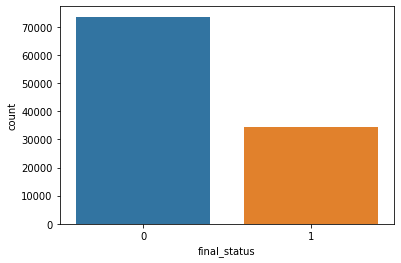

In [11]:
# 투자유치를 받는경우 == 1, 받지못한 경우 == 0 / 이 특성을 Target으로 잡을 것이고 이들의 분포를 시각화하여 확인
sns.countplot(x='final_status',data=df)
plt.show()

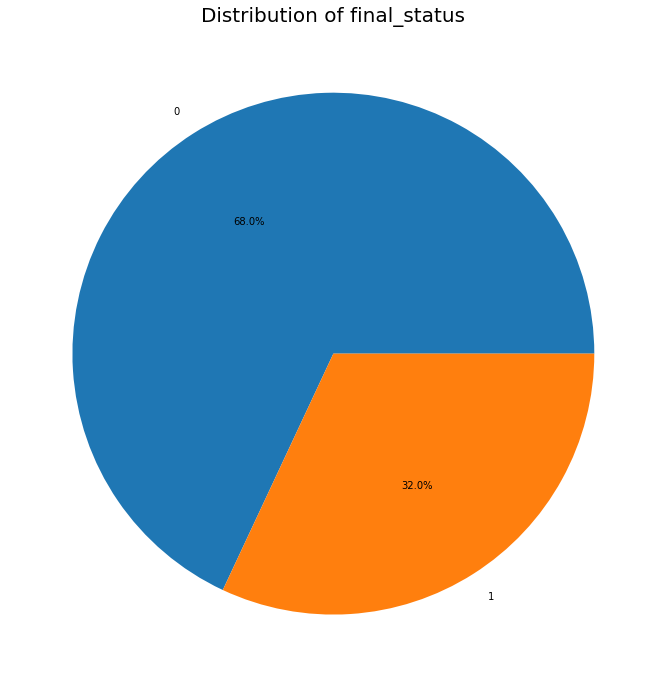

In [12]:
#target을 투자금 승인==1 or 불허==0 라는 범주형으로 두 카테고리 중 하나로 정해지는 모델을 만들 예정이기에 분류문제로 구분함.
bar, ax = plt.subplots(figsize = (12,12))
plt.pie(df['final_status'].value_counts(), labels = df['final_status'].value_counts().index, autopct="%.1f%%")
plt.title('Distribution of final_status', size=20);
#다수 클래스(majority class) 비율이 65~70% 범위 안에 밸런스를 유지하고 있음

In [13]:
df['goal'].astype(float)

0            20.0
1           300.0
2            30.0
3           500.0
4          2000.0
           ...   
108124     2000.0
108125    15000.0
108126      320.0
108127    35000.0
108128    25000.0
Name: goal, Length: 108129, dtype: float64

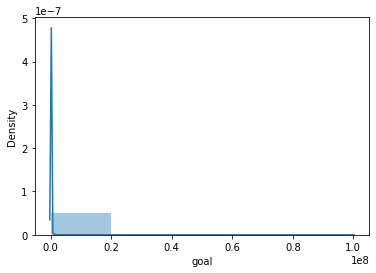

In [14]:
sns.distplot(df['goal'], bins=5)
plt.show();#목표금액

In [15]:
df['goal'].describe()

count    1.081290e+05
mean     3.672623e+04
std      9.719027e+05
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.300000e+04
max      1.000000e+08
Name: goal, dtype: float64

In [16]:
#아웃라이어 제거하고 시각화 다시하기
P = np.percentile(df['goal'], [0, 95])
new_goal = df[(df['goal'] > P[0]) & (df['goal'] < P[1])]

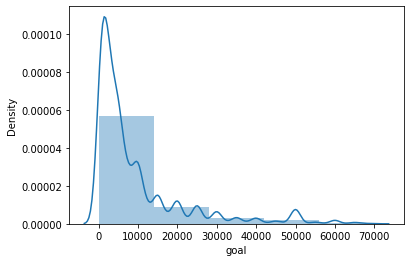

In [17]:
sns.distplot(new_goal['goal'], bins=5)
plt.show()

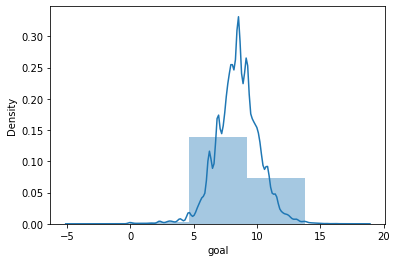

In [18]:
# 아웃라이어 제외하고 로그화 시켜서 분포도 재설정한 것 시각화
sns.distplot(np.log(df['goal']), bins=5)
plt.show()
#####로그를 해주는 이유는 일단 독립변수가 몇% 변할때 종속변수가 몇%변하는지를 변화량일 비율로 보고자 할 때 독립변수와 종속변수에 모두 자연로그(Ln)를 취해줍니다.
#####독립변수에 자연로그를 취해주면 독립변수가 1% 변할 때 종속변수도 얼마만큼의 양이 변하는것을 확인 할 수 있는데, 일반적으로 자연로그를 씌우면 비선형관계를 선형관계로 변환할수 있기 때문입니다
##### (회귀분석의 전제는 x와 y가 선형관계이어야 하기 때문에 회귀분석을 하기 위해 그렇게 해주는 것이다.)



이렇게 자연로그화 한 후 확인해 보았을 때 대부분의 프로젝트가 2만 달러 밑이므로 제대로 투자를 못 받지 못한것으로 보여집니다. 그렇다면 목표 투자금이 나라나 화폐종류에 상관관계가 있는지 시각화로 살펴보겠습니다.

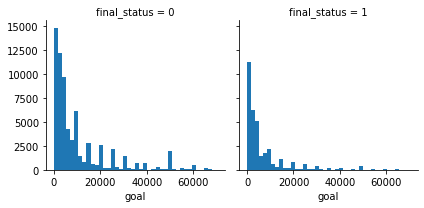

In [19]:
g = sns.FacetGrid(new_goal, col='final_status')
g.map(plt.hist, 'goal', bins = 40)
plt.show()

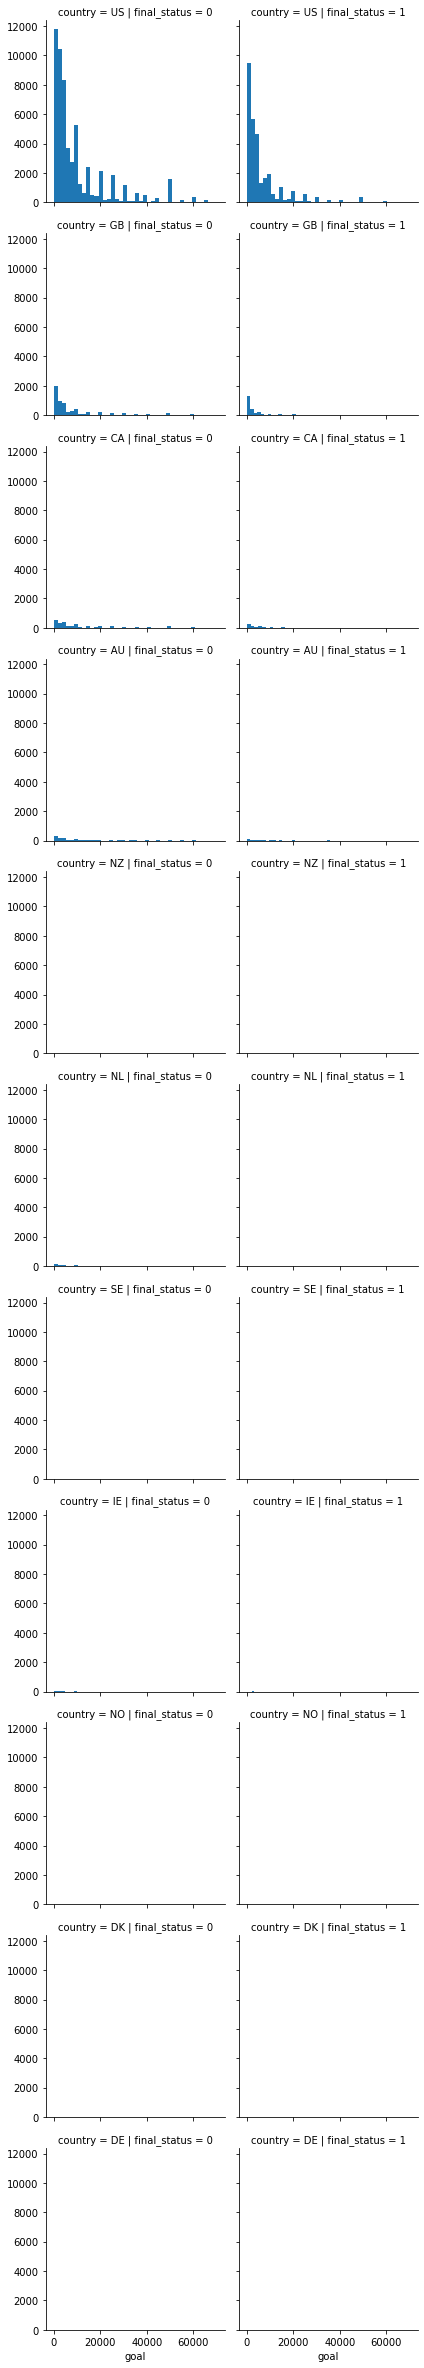

In [20]:
g = sns.FacetGrid(new_goal, col="final_status",  row="country")
g = g.map(plt.hist, "goal", bins = 40)
plt.show()

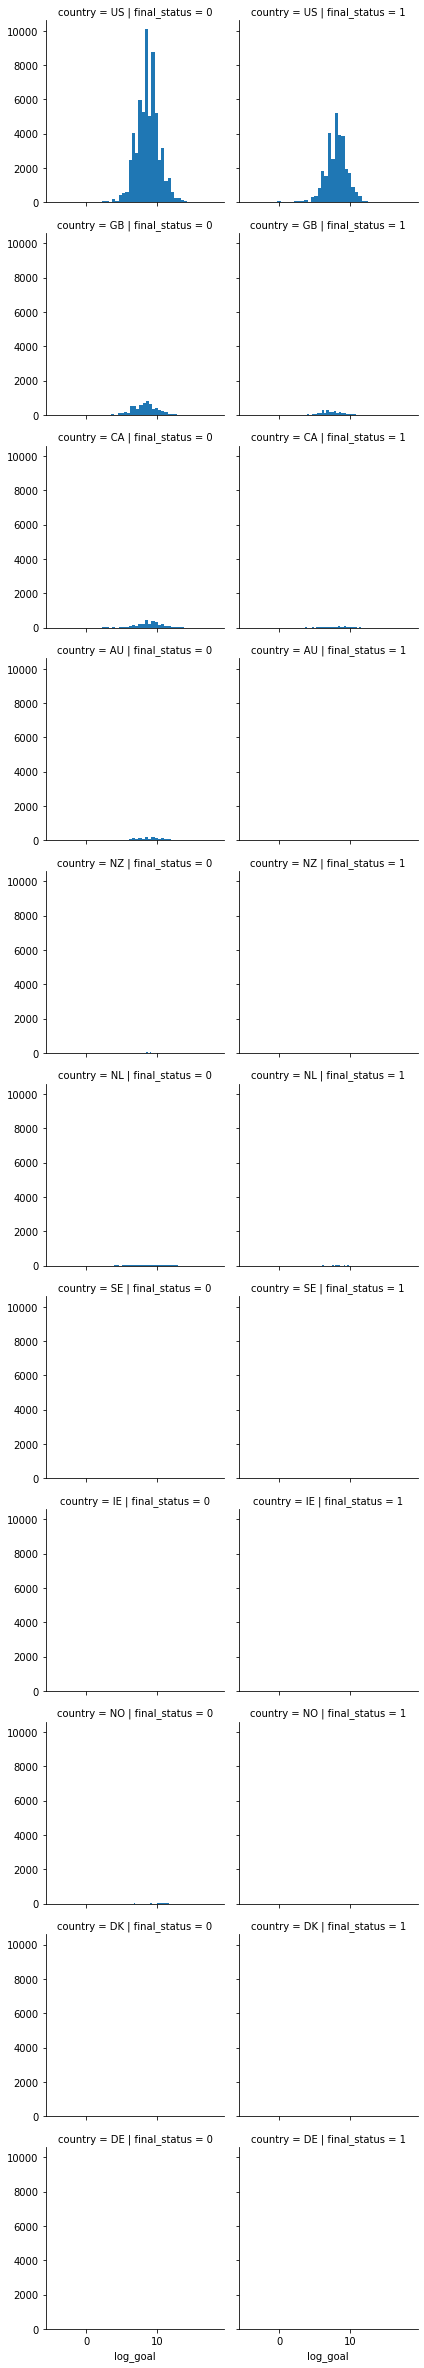

In [21]:
#non_us = new_goal[new_goal['country'] != 'US']
df['log_goal'] = np.log(df['goal'])
g = sns.FacetGrid(df, col="final_status",  row="country")
g = g.map(plt.hist, "log_goal", bins = 40)



disable_communication 특성이 좋은 특성으로 포함되어있지 않은것 같습니다. 왜냐하면 대부분의 프로젝트가 communication-disabled 이기 때문입니다. 

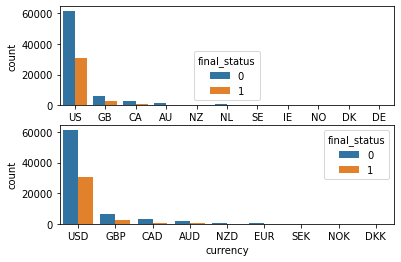

In [22]:
figure, axes = plt.subplots(2)
sns.countplot(x='country',data=df, hue='final_status', ax = axes[0])
sns.countplot(x='currency',data=df, hue='final_status', ax = axes[1])
plt.show() ### 나라와의 연관성에서는 미국달러가 대부분의 분포를 차지하고 있습니다
          ### 화폐 또한 나라와의 분포와 비슷한 양상을 보입니다. 

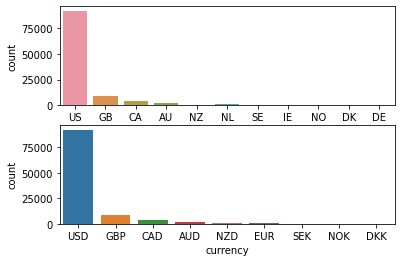

In [23]:
figure, axes = plt.subplots(2)
sns.countplot(x='country',data=df, ax = axes[0])
sns.countplot(x='currency',data=df, ax = axes[1])
plt.show()


이러한 화폐에서의 목표투자금액 시각화에서 볼 수 있듯이, SEK,NOK,DKK 화폐 종류를 제거 할 수 있습니다.(아웃라이어를 직관적으로 판단할 수 있습니다) 그렇기에 위의 화폐종류 데이터들은 예측모델을 만들 때 사용되지 않을것이며, 또한, 이 부분을 제거해주는게 인코딩작업을 할 때 훨씬 깨끗하고 수월하게 해줄 수 있을 것입니다.

이번에는 프로젝트 투자금 유치를 성공적으로 할 수 있었는지 없었는지에 대하여 각 프로젝트 마다의 후원자 수가 영향을 끼쳤는지에 대하여 알아보겠습니다.

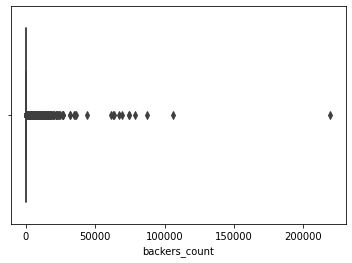

In [24]:
#박스플랏으로 시각화, 대부분이 0~45000 사이 에 분포하고 있음을 볼 수 있다.
ax = sns.boxplot(x=df["backers_count"])


In [25]:
#히스토그램으로 시각화하여 아웃라이어 제거해보기
P_backer = np.percentile(df['backers_count'], [0, 95])
new_backers = df[(df['backers_count'] > P_backer[0]) & (df['backers_count'] < P_backer[1])]

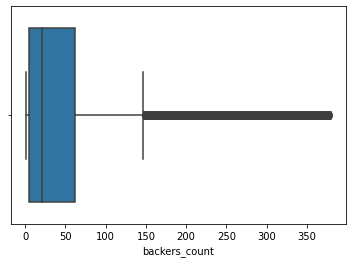

In [26]:
ax = sns.boxplot(x=new_backers["backers_count"])

In [27]:
new_backers.shape

(89887, 15)

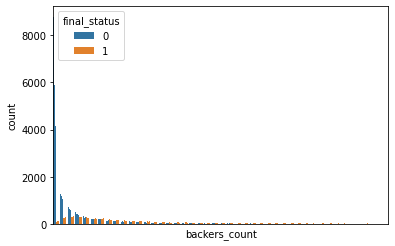

In [28]:
#후원자 숫자에 의한 투자승인 여부 시각화
# figure, axes = plt.subplots(1, 2, sharey=True)
sns.countplot(x='backers_count',data=new_backers, hue='final_status')
plt.xticks([],[])
# sns.countplot(x='final_status', data= df, ax = axes[1])
plt.show()

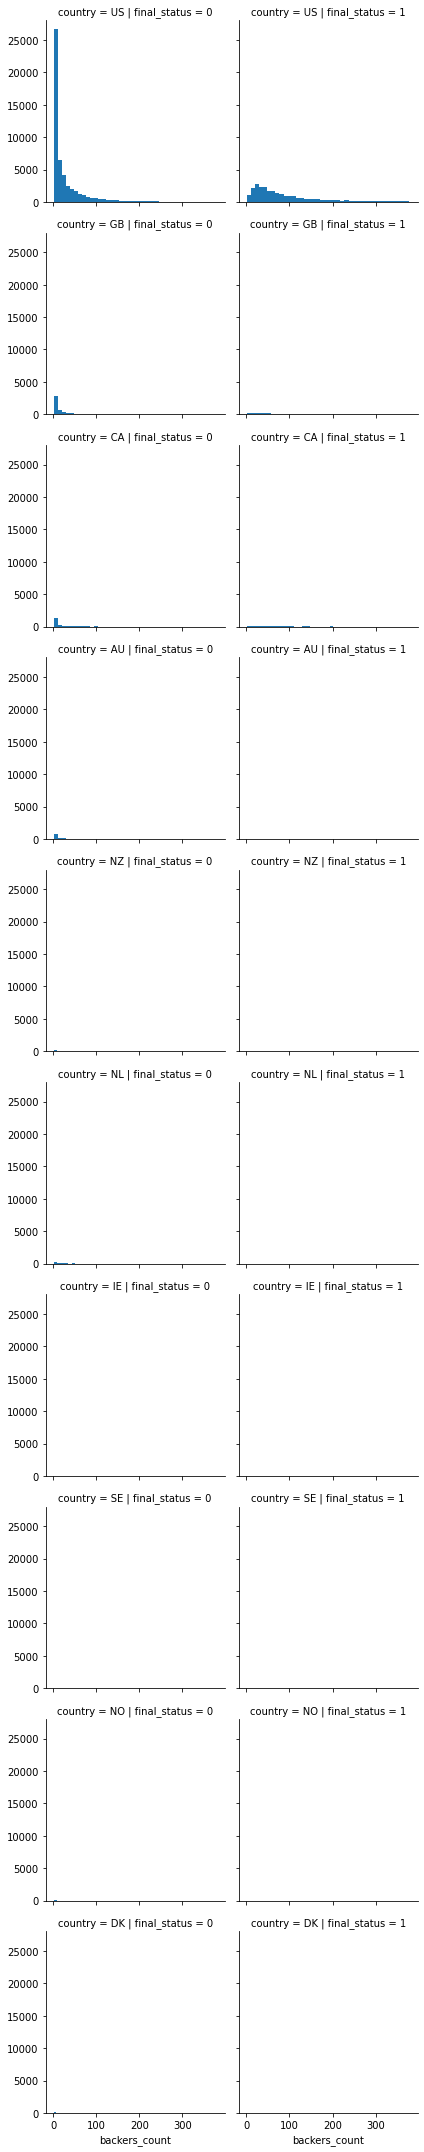

In [29]:
#나라별 승인여부 시각화
g = sns.FacetGrid(new_backers, col="final_status",  row="country")
g = g.map(plt.hist, "backers_count", bins = 40)

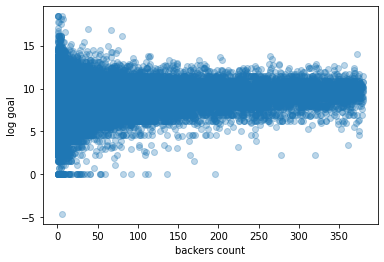

In [30]:
plt.scatter(new_backers['backers_count'], np.log(new_backers['goal']), alpha = 0.3)
plt.xlabel('backers count')
plt.ylabel('log goal')
plt.show()#목표투자금액과 후원자수와의 관계를 알아보기 위하여 스캐터플랏 시각화

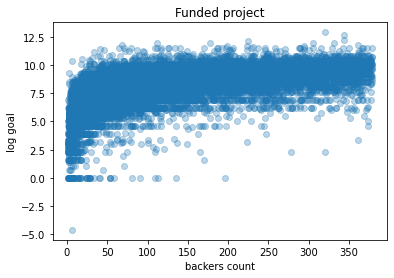

In [31]:
plt.scatter(new_backers[new_backers['final_status'] == 1]['backers_count'], np.log(new_backers[new_backers['final_status'] == 1]['goal']), alpha = 0.3)
plt.xlabel('backers count')
plt.ylabel('log goal')
plt.title("Funded project")
plt.show()#투자금을 받는경우에, 목표투자금액과 후원자수와의 관계 시각화

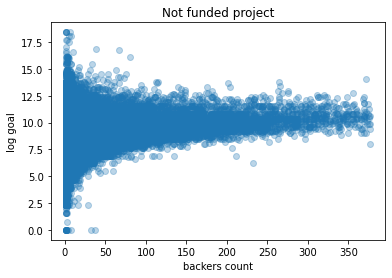

In [32]:
plt.scatter(new_backers[new_backers['final_status'] == 0]['backers_count'], np.log(new_backers[new_backers['final_status'] == 0]['goal']), alpha = 0.3)
plt.xlabel('backers count')
plt.ylabel('log goal')
plt.title("Not funded project")
plt.show()#투자금을 받지 못하는경우, 목표투자금액과 후원자수와의 관계 시각화

In [33]:
#프로젝트 론칭 분기를 4분기로 나누어주는 함수
def countQuarter(dt):
    month = int(dt[5:7])
    if month <= 3: return '01'
    elif month <= 6:return '02'
    elif month <= 9: return '03'
    else: return '04'

df['launched_month'] = df['launched_at'].apply(lambda dt: dt[5:7])
df['launched_year'] = df['launched_at'].apply(lambda dt: dt[0:4])
df['launched_quarter'] = df['launched_at'].apply(lambda dt: countQuarter(dt))

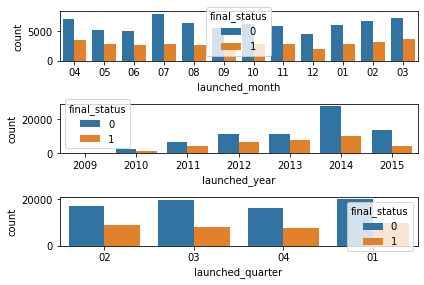

In [34]:
figure, axes = plt.subplots(3)
sns.countplot(x='launched_month',data=df, hue='final_status', ax = axes[0])
sns.countplot(x='launched_year',data=df, hue='final_status', ax = axes[1])
sns.countplot(x='launched_quarter',data=df, hue='final_status', ax = axes[2])
plt.tight_layout()
plt.show() # 출시 월, 연도, 분기 별 투자 유치 성공 및 실패 분포를 나타내주는 그래프 시각화

In [35]:
def measureDuration(dt): # Duration in hours
    launch = datetime.strptime(dt[0], "%Y-%m-%d %H:%M:%S")
    deadline = datetime.strptime(dt[1], "%Y-%m-%d %H:%M:%S")
    difference = deadline-launch
    hr_difference = int (difference.total_seconds() / 3600)
    return hr_difference
# 론칭 시작 후 마감날짜까지의 시간을 한시간을 기준으로 나누어주었을 때를 나타내주는 새로운 특성 생성
df['duration'] = df[['launched_at', 'deadline']].apply(lambda dt: measureDuration(dt), axis=1)

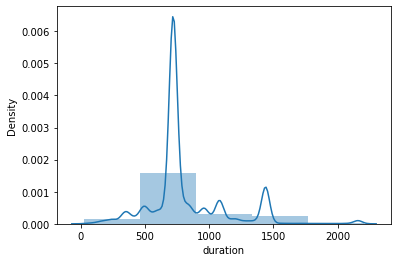

In [36]:
sns.distplot(df['duration'], bins=5)
plt.show()

In [37]:
def measureDurationByWeek(dt):
    # count by hr / week 
    week = 168 
    return int (dt / 168)
# 지속시간을 론칭 기간의 총 week 수로 나누값으로하는 새로운 특성 생성
df['duration_weeks'] = df['duration'].apply(lambda dt: measureDurationByWeek(dt))

In [38]:
df['launched_year'].value_counts()

2014    37526
2013    19148
2012    18204
2015    17737
2011    10683
2010     4221
2009      610
Name: launched_year, dtype: int64

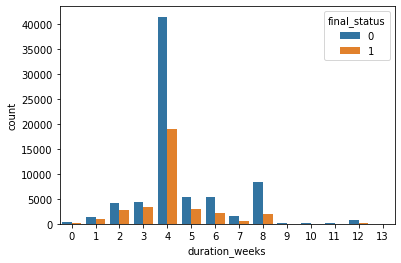

In [39]:
sns.countplot(x='duration_weeks', data=df, hue='final_status')
plt.show()#승인여부별, 각 프로젝트 기간을 주단위로 나타낸 그래프를 시각화

In [40]:
df.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status,log_goal,launched_month,launched_year,launched_quarter,duration,duration_weeks
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,2009-05-03 06:59:59,2009-05-03 07:00:17,2009-04-24 19:15:07,2009-04-24 19:52:03,3,1,2.995732,04,2009,02,203,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,2009-05-15 23:10:00,2009-05-16 00:00:18,2009-04-28 23:10:24,2009-04-29 03:26:32,2,0,5.703782,04,2009,02,403,2
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,False,US,USD,2009-05-22 21:26:00,2009-05-22 21:30:18,2009-05-12 21:26:53,2009-05-12 21:39:58,0,0,3.401197,05,2009,02,239,1
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0,help-me-write-my-second-novel,False,US,USD,2009-05-29 00:09:00,2009-05-29 00:15:21,2009-04-29 00:09:55,2009-04-29 00:58:50,18,1,6.214608,04,2009,02,719,4
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0,support-casting-my-sculpture-in-bronze,False,US,USD,2009-05-31 11:38:00,2009-05-31 11:45:17,2009-05-01 11:38:34,2009-05-01 12:22:21,1,0,7.600902,05,2009,02,719,4


In [41]:
df.nunique()

project_id               108129
name                     107838
desc                     107377
goal                       3567
keywords                 108129
disable_communication         2
country                      11
currency                      9
deadline                 100933
state_changed_at         102417
created_at               108062
launched_at              108039
backers_count              2426
final_status                  2
log_goal                   3567
launched_month               12
launched_year                 7
launched_quarter              4
duration                   1889
duration_weeks               14
dtype: int64

In [42]:
# 프로젝트 이름안에 있는 단어 수를 기반으로 하는 새 특성 생성
df['name_length'] = df['name'].apply(lambda name: len(str(name)))

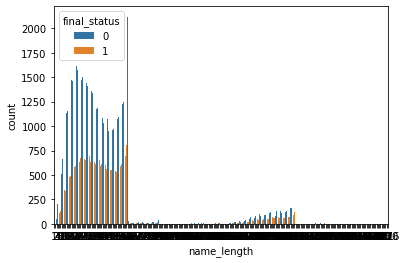

In [43]:
sns.countplot(x='name_length', data=df, hue='final_status')
plt.show()

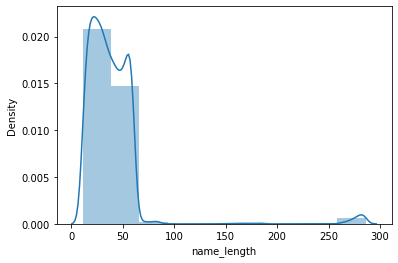

In [44]:
P = np.percentile(df['name_length'], [5, 95])
parsed_name = df[(df['name_length'] > P[0]) & (df['name_length'] < P[1])]

sns.distplot(parsed_name['name_length'], bins=10)
plt.show()

In [45]:
df['name_length'].nunique()

269

In [46]:
df = df.loc[df['name_length'] < 80]  #아웃라이어 제거

In [47]:
df.shape

(100632, 21)

In [48]:
df['name_length'].nunique()

79

In [49]:
import plotly.express as px
diagram_name = df['name_length'].value_counts().reset_index()
diagram_name = diagram_name[diagram_name['name_length'] /  diagram_name['name_length'].sum() > 0.01]

fig = px.pie(diagram_name, values='name_length', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(); #'name_length'특성 unique들 분포 다이어그램으로 시각화하여 확인하기

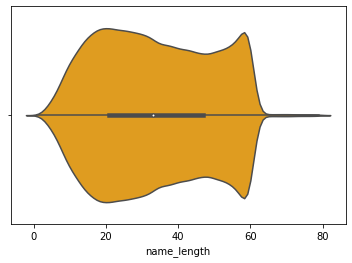

In [50]:
sns.violinplot(df.name_length,color='orange'); #아웃라이어를 확인하기위한 바이올린 플랏

In [51]:
df.shape

(100632, 21)

In [52]:
#high cardinility 특성들, identification 특성들 및 의미없는 특성들 drop 후 최종 features 선정
features = ['country', 'currency', 'launched_year', 'launched_month', 'duration_weeks', 'name_length']
target = 'final_status'

In [53]:
df[features].nunique()

country           11
currency           9
launched_year      7
launched_month    12
duration_weeks    14
name_length       79
dtype: int64

###전처리 및 feature engineering 결과 모델을 만들기위하여 6가지 특성만이 남았고 특성 수가 많지 않기에 k_selection 등과 같이 상관관계가 높은 특성들을 선별하는 방식등을 사용하지 않아도 된다고 판단. 모든 6개의 특성들을 다 사용해서 예측 모델을 만들겠습니다.

In [54]:
###트레인 데이터와 테스트 데이터로, 8:2 비율로 랜덤하게 분할하겠습니다
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=2)
train.shape, test.shape

((80505, 21), (20127, 21))

###검증 방식 (Cross-validation)을 정한 후 간단하게 4가지 종류의 모델들을 학습

In [55]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [56]:
X_train.nunique()

country           11
currency           9
launched_year      7
launched_month    12
duration_weeks    14
name_length       79
dtype: int64

#기준모델(분류) 설정하기

In [57]:
# 분류문제를 풀기전에 항상 먼저 타겟 범주가 어떤 비율을 가지고 있는지 확인해 보아야 합니다
y_train.value_counts(normalize=True)

0    0.681784
1    0.318216
Name: final_status, dtype: float64

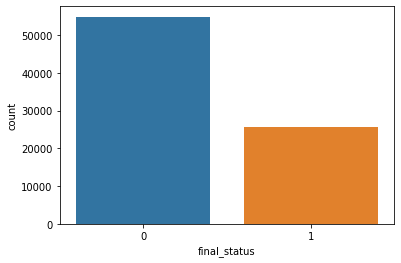

In [58]:
# 투자유치를 받는경우 == 1, 받지못한 경우 == 0 / 이 특성을 Target으로 잡을 것이고 이들의 분포를 시각화하여 확인
%matplotlib inline
sns.countplot(x=y_train);
#분류문제에서는 보통 타겟 변수에서 가장 빈번하게 나타나는 범주를 기준모델로 설정합니다.

In [59]:
# 분류문제의 기준모델설정
# 범주 0 으로 모든 예측 실시
# mode(): 가장 많은 빈도로 나온 값을 가져온다. 뒤에 [0] 붙일 경우, 그 값들 중에서도 가장 많은 값 반환 
major = y_train.mode()[0] # 0을 반환함

# 타겟 샘플 수 만큼 1이 담긴 리스트 생성 (기준모델로 예측)
y_pred = [major] * len(y_train)
print(y_pred)
# 기준모델의 예측성능 확인함
# 분류모델의 Evaluation Metrics = accuarcy score(정확도) = 정확한 예측수 / 전체 예측수

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [60]:
# 최다 클래스의 빈도가 정확도가 됩니다.
from sklearn.metrics import accuracy_score
print("training accuracy: ", accuracy_score(y_train, y_pred))

training accuracy:  0.6817837401403639


In [61]:
# 검증세트 에서도 정확도를 확인해 볼 수 있습니다.
y_test = test[target]
y_pred = [major] * len(y_test)
print("test accuracy: ", accuracy_score(y_test, y_pred))

test accuracy:  0.6826153922591544


# Decission trees / Random Forest/  Logistic Regression / Cross Gradient Booster 모델을 만들어 학습해보고 score 확인

In [62]:
encoder = TargetEncoder()
X_train_encoded = encoder.fit_transform(X_train, y_train) # 학습데이터
X_test_encoded = encoder.transform(X_test) # 검증데이터
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

In [63]:
####여러 모델 만들어 적용하기
# Predefined function
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

def model_assess(model, name='Default'):
    model.fit(X_train_imputed, y_train)
    preds = model.predict(X_test_imputed)
    print('---', name, '---', '\n',
          confusion_matrix(y_test, preds), '\n',
          'Accuracy:', round(accuracy_score(y_test, preds), 5), '\n')

In [64]:

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, 'Decission Trees')

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, 'Random Forest')


# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, 'Logistic Regression')

from xgboost import XGBClassifier, XGBRFClassifier
# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, 'XGBoost')



--- Decission Trees --- 
 [[11421  2318]
 [ 5027  1361]] 
 Accuracy: 0.63507 

--- Random Forest --- 
 [[13491   248]
 [ 6133   255]] 
 Accuracy: 0.68296 

--- Logistic Regression --- 
 [[13414   325]
 [ 6112   276]] 
 Accuracy: 0.68018 

--- XGBoost --- 
 [[13350   389]
 [ 5988   400]] 
 Accuracy: 0.68316 



위 4가지 간단한 모델을 만들어 성능을 비교하였을 때 XGBoost 모델 및 Randome Forest 모델의 성능이 가장 좋은것으로 나왔습니다. 이를 바탕으로 두 모델에 교차검증등을 활용하여 일반화가 잘되었는지를 확인해보고, RandomizedSearchCV 등을 활용하여 hyperparameter들을 세부적으로 수정하여서(ex,class weight=balanced. etc) 더 좋은 성능을 낼 수 있도록 만들어보겠습니다.
그리고 최종적으로 만들어진 모델들을 가지고 baseline모델에서의 성능과 비교해보도록하겠습니다. 그리고 permutation importance, pdp 및 shap value 시각등을 활용하여 모델의 설명력을 높혀보도록 노력해보겠습니다.
\
\
추가적으로 XGBRFboost와 같이 랜덤포레스트와 XGBoost를 복합적으로 함께 사용하는 모델을 만들 수도 있습니다. 이는 차후에 기회가 된다면 다루어보겠습니다.

1) RandomForestClassfier 모델

In [65]:
#RandomForestClassfier 모델 생성
pipe = make_pipeline(
     TargetEncoder(),
     SimpleImputer(), 
     RandomForestClassifier(class_weight='balanced', random_state=2) #max_depth=5,를 안주고 default 값인 전체 leaf 로 계산하는 파라미터 설정
)
### class_weight 의 balnace 조절을 하고 학습한 모델
k = 3 #세번의 검증

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='accuracy')

print(f'accuracy for {k} folds:', scores)  #검증 방식 (Cross-validation)의 평가지표 (RandomizedSearchCV를 통한 하이퍼파라미터 수정 전)
pipe.fit(X_train, y_train)
print('테스트셋 정확도: ', pipe.score(X_test, y_test)) #테스트셋에서의 성능 확인

accuracy for 3 folds: [0.59008757 0.59370225 0.58997578]
테스트셋 정확도:  0.5874695682416654


In [66]:
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_test_encoded)
print(classification_report(y_test, y_pred)) #Class_weight로 타겟 클래스 비중을 균형있게 만들지 않은 모델의 지표(Metric) 살펴보기

              precision    recall  f1-score   support

           0       0.69      0.77      0.73     13739
           1       0.35      0.26      0.30      6388

    accuracy                           0.61     20127
   macro avg       0.52      0.52      0.51     20127
weighted avg       0.58      0.61      0.59     20127



In [67]:
dists = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1)
}

pipe_cv = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=5, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)
############이거는 되네...? 일단 이 모델을 사용!
pipe_cv.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('targetencoder',
                                              TargetEncoder(cols=['country',
                                                                  'currency',
                                                                  'launched_year',
                                                                  'launched_month'])),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=2))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                

In [68]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
pipe_cv_best = pipe_cv.best_estimator_

In [69]:
y_pred_pipe_cv_best = pipe_cv_best.predict(X_test)
print(classification_report(y_test, y_pred_pipe_cv_best))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69     13739
           1       0.38      0.44      0.41      6388

    accuracy                           0.59     20127
   macro avg       0.55      0.55      0.55     20127
weighted avg       0.61      0.59      0.60     20127



In [70]:
###hyper parameters optimzed by 그리드SearchCV##############################################################
from sklearn.model_selection import GridSearchCV
params = { 'n_estimators' : [10, 100],
#           'max_depth' : [6, 8, 10, 12],#시간상 생략
           'min_samples_leaf' : [8, 18],
#           'min_samples_split' : [8, 16, 20]#시간상 생략
            }
rf = RandomForestClassifier(class_weight='balanced', random_state=2)
grid_search = GridSearchCV(rf, param_grid = params, 
                          cv = 3, n_jobs = -1, verbose = 2)
#################-------------------------------------------GridSearchCV----------------------------------------------------------------------------
#dists = {
#    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.], # int로 넣으면 error(bug)
#    'targetencoder__min_samples_leaf': randint(1, 10),     
#    'simpleimputer__strategy': ['mean', 'median'], #Xgboost 에서는 missing value 처리해주기 때문에 이거는 dists 에서 제외시켜도 될듯...
#    'randomforestclassfier__n_estimators': randint(50, 500), 
#    'randomforestclassfier__max_depth': [5, 10, 15, 20, None], 
#    'randomforestclassfier__max_features': uniform(0, 1) # max_features
#}
###########왜 타겟인코더,임퓨터 랜덤포레스트클래스피어로 짠 파이프라인에다가 RandomizedSearchCV를 했을 경우 오류가 나는걸까? 알아보자!###############
#pipe_cv = RandomizedSearchCV(
#    rf, 
#    param_distributions=dists, 
#    n_iter=5, 
#    cv=3, 
#    scoring='accuracy',  
#    verbose=1,
#    n_jobs=-1
#)

grid_search.fit(X_train_encoded, y_train);
#pipe_cv.fit(X_train_encoded, y_train);

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [71]:
print('최적 하이퍼파라미터: ', grid_search.best_params_)
print('accuracy: ', grid_search.best_score_)

최적 하이퍼파라미터:  {'min_samples_leaf': 8, 'n_estimators': 100}
accuracy:  0.5876529408111297


In [72]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
pipe_final = grid_search.best_estimator_

In [73]:
from sklearn.metrics import mean_absolute_error, accuracy_score
#그리드서치씨비로 최적화되어진 RandomForestClassfier모델을 가지고 테스트셋에서의 accuracy, precision 및 recall 지표를 살펴보겠습니다.
y_pred = pipe_final.predict(X_test_encoded)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66     13739
           1       0.39      0.57      0.46      6388

    accuracy                           0.58     20127
   macro avg       0.57      0.58      0.56     20127
weighted avg       0.63      0.58      0.60     20127



2)XGBClassifier 모델

In [74]:
vc = y_train.value_counts().tolist()
vc

[54887, 25618]

In [75]:
# sum(negative instances) / sum(positive instances)
ratio = float(vc[0]/vc[1])
ratio

2.142516980248263

In [76]:
from xgboost import XGBClassifier
boosting = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=5,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2,
    scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)
####################################################xgb부스터는 simpleimputer를 기본제공하기에 인코딩 된 데이터값만 쓰여도 됨
eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 500 rounds 동안 스코어의 개선이 없으면 멈춤





[0]	validation_0-error:0.396944	validation_1-error:0.409152
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.433489	validation_1-error:0.444825
[2]	validation_0-error:0.407478	validation_1-error:0.421076
[3]	validation_0-error:0.40903	validation_1-error:0.421126
[4]	validation_0-error:0.409304	validation_1-error:0.421523
[5]	validation_0-error:0.408472	validation_1-error:0.420579
[6]	validation_0-error:0.409217	validation_1-error:0.421821
[7]	validation_0-error:0.409428	validation_1-error:0.421672
[8]	validation_0-error:0.411341	validation_1-error:0.423312
[9]	validation_0-error:0.410596	validation_1-error:0.423262
[10]	validation_0-error:0.41036	validation_1-error:0.424008
[11]	validation_0-error:0.411478	validation_1-error:0.425001
[12]	validation_0-error:0.413142	validation_1-error:0.426641
[13]	validation_0-error:0.411999	validation_1-error:0.4252

XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=1000, n_jobs=-1,
              scale_pos_weight=2.142516980248263)

In [77]:
k = 3 #세번의 검증

scores = cross_val_score(boosting, X_train_encoded, y_train, cv=k, 
                         scoring='accuracy')
print(f'accuracy for {k} folds:', scores)  #검증 방식 (Cross-validation)의 평가지표 (RandomizedSearchCV를 통한 하이퍼파라미터 수정 전)

print('테스트셋 정확도: ', boosting.score(X_test_encoded, y_test)) #테스트셋에서의 성능 확인

accuracy for 3 folds: [0.57872182 0.57369108 0.57503261]
테스트셋 정확도:  0.5908481144730958


In [78]:
y_pred_boosting = boosting.predict(X_test_encoded)###RandomizedSearchCV를 통해 파라미터 찾아주는 과정을 하기전에 만들어져있던 부스팅모델을가지고 테스트셋에서 metric 점수 확인
print(classification_report(y_test, y_pred_boosting))

              precision    recall  f1-score   support

           0       0.75      0.61      0.67     13739
           1       0.40      0.56      0.46      6388

    accuracy                           0.59     20127
   macro avg       0.57      0.58      0.57     20127
weighted avg       0.64      0.59      0.60     20127



In [79]:
###hyper parameters optimzed by RandomizedSearchCV######################################################
dists = {
#    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 10),     
#    'simpleimputer__strategy': ['mean', 'median'], #Xgboost 에서는 missing value 처리해주기 때문에 이거는 dists 에서 제외시켜도 될듯...
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1) # max_features
}
####왜 xgbclassifier는 램덤포레스트 클래시피어 파라미터 위와같은게 있어도 오류뜨지 않는걸까? 찾았다.... class'i'fier <- i 철자 하나 빠트려서 안되는거였음...모든오류의원흉.. 해답찾음..!
boosting_cv = RandomizedSearchCV(
    boosting, 
    param_distributions=dists, 
    n_iter=5, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

boosting_cv.fit(X_train_encoded, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [80]:
print('최적 하이퍼파라미터: ', boosting_cv.best_params_)
print('accuracy: ', boosting_cv.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.8716871773729779, 'randomforestclassifier__n_estimators': 53, 'targetencoder__min_samples_leaf': 2}
accuracy:  0.5758151667598286


In [81]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
boosting_final = boosting_cv.best_estimator_

In [82]:
from sklearn.metrics import mean_absolute_error, accuracy_score
#최적화되어진 XGBClassifier모델을 가지고 테스트셋에서의 accuracy, precision 및 recall 지표를 살펴보겠습니다.
y_pred_final = boosting_final.predict(X_test_encoded)
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.76      0.54      0.63     13739
           1       0.39      0.64      0.48      6388

    accuracy                           0.57     20127
   macro avg       0.58      0.59      0.56     20127
weighted avg       0.64      0.57      0.58     20127



**Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?**

Data leakage는 없었습니다. 이유는 데이터 누출이 일어나지 않도록 사전에 feature engineering을 통하여 이를 예방하였고 완성된 모델들의 성능지표를 분석하였을 때 데이터 누출을 의심할 이유가 없었습니다.

**만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?**
앞선 시나리오에서 언급했듯이, 자신의 프로젝트에 투자금 얻은 지원자들의 데이터를 기반으로 어떠한 특성들이 이의 투자 승인여부에 영향을 미치는지 분석해보고 수많은 지원자들중에서 어떤 지원자들이 투자금을 받을만한지를 확인하는데에 객관적으로 접근해볼 수 있을 것입니다. 어떠한 공통된 특징들이 존재함으로써 이러한 승인여부 결과를 도출할 수 있다는 가설에 기반하여 만들어진 모델이고 이는 프로젝트 투자 과정에 소요되는 시간을 줄일 수 있을뿐만 아니라 주관적인 판단보다는 객관화 되어진 결과로 의사결정을 내릴 수 있음에 도움이 될 수 있을 것이라 생각합니다. 하지만 투자 승인을 받은 각각의 프로젝트마다  성공적인 결과를 낸다는 사실여부에 대한 데이터 특성이 없기에 이 모델의 예측은 긍정적인 결과를 낼 것이라는 근거가 존재하지 않습니다. 그 밖에, 적은 특성 수들에 의하여 만들어진 모델이기에 이러한 예측 결과를 뒷받침할 충분한 근거가 될 수 없다는것이 한계일 것입니다.

###최종모델 선택.(XGBClassifier 를 RandomizedSearchCV를 통하여 개선시킨 모델)

**모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 
무엇일까요?** 

우선 결론말 말씀드리자면 베이스라인보다 accuracy점수가 낮게 나왔습니다. 이러한 이유에는 타겟의 분포 비율이 한쪽으로 지나치게 분포되어있기에 모델이 학습시 과적합 학습을하여 일반화를 잘 못한 경우일 수 있습니다. 그렇기에 단순히 accuracy 성능 점수만 보기보다는 racall 과 precision의 점수와 비율이 잘 맞는지에 대해 초점을 맞추어보아야합니다. 그렇기에 위의 두 모델(랜덤포레스트클래시피어, xgbclassifier)은 accuracy 점수가 베이스라인모델 점수에비해 상대적으로 낮았지만 recall 과 precision의 점수가 높아지고 비율이 좀 더 고루 분포되어진 지표를 보여주고 있습니다. 이것은 모델이 예측할 때 일반화를 더 잘해서 좀 더 나은 예측을 할 수 있다는 것을 의미합니다.


**모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?**


모델 성능 개선을 위하여 RandomizedSearchCV 및 gridsearchCV 와 같이 최적화된 모델을 만들려고 하였습니다. 세부적으로 하이퍼파라미터들의 수정에 의하여 recall 값 및 precision 값의 개선을 볼 수 있었습니다.

**최종 모델에 관해 설명하세요.**


최종모델은 xgbclassifier 를 randomizedsearchcv를 통하여 개선시킨 모델입니다. 베이스라인모델이나 randomforestclassifier 모델보다 accuracy가 낮았지만 precision 및 recall값의 개선으로 과적합 학습이 된 모델이 아닌 일반화를 잘할 수 있는 모델을 만들었습니다. 이 모델을 통하여 어떤 특성들이 예측하는데에 있어서 영향을 주는지 데이터 하나는 타겟과 어떤 상관관계를 가지는지를 pdp 및 shap 시각화를 통하여 설명하도록 해보겠습니다.

**서로 관련이 있는 모든 특성들에 대한 전역적인(Global) 설명**

**Feature Importances**


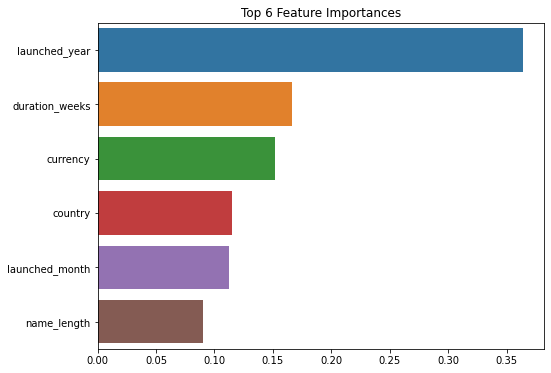

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
######특성이 적어 mean k best 를 통해 피쳐를 줄여서 찾을 필요가 없었지만 피쳐중 어떤것이 가장 최종모델이 예측하는데에있어서 영향을 많이 줬는지를 시각화하였음.
ftr_importances_values = boosting_final.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:6]

plt.figure(figsize=(8,6))
plt.title('Top 6 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()


**Permutation Importances**

In [84]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=boosting_final, random_state=1)
perm.fit(X_test_encoded, y_test)

eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0554 ± 0.0037,launched_year
0.0300 ± 0.0055,launched_month
0.0172 ± 0.0040,duration_weeks
0.0079 ± 0.0040,name_length
-0.0008 ± 0.0020,currency
-0.0019 ± 0.0014,country


**Permutation 및 feature importances 두 시각화에대한 결과 해석 :**

 특성이 적어 mean k best 를 통해 피쳐를 줄여서 찾을 필요가 없었지만 피쳐중 어떤것이 가장 최종모델이 예측하는데에있어서 영향을 많이 줬는지를 시각화하였음. 출시연도가 가장 중요한 영향력을 가진 특성임을 보여주고 있습니다.
 순열중요도는 무작위로 데이터의 배열을 바꿔 제 기능을 못하게 하여 각 특성의 중요도를 계산한 것인데 여기서는 launched year 및 launched month 및 duration weeks의 특성이 다른 특성에 비하여 순차적으로 높음을 나타내준다. 어떤 모델에 학습하건 이 특성의 중요도는 바뀌지 않는다. 이는 명백히 feature importance와의 차이임을 알려준다.

**타겟과 관련이 있는 개별 특성들에 대한 전역적인 설명**

**Partial Dependence plots(PDP)**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


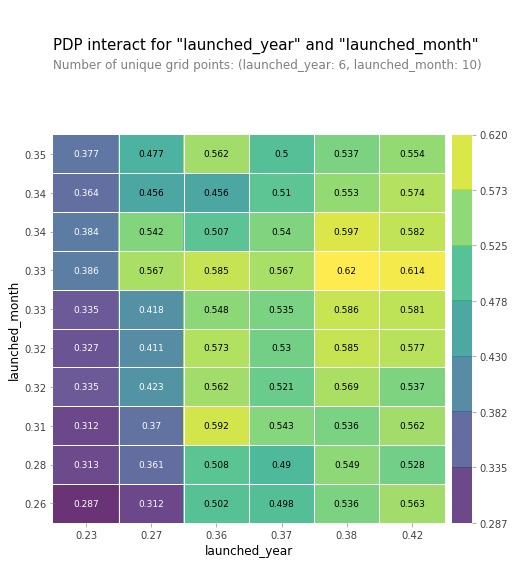

In [85]:
# 2D PDP
import matplotlib.font_manager
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['launched_year', 'launched_month']

interaction = pdp_interact(
    model=boosting_final, 
    dataset=X_test_encoded, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

**launched_month 및 launched_year 두 특성간의 상호작용에 대하여 시각화하였고 이에 인코딩 되어지기전 서로의 값에 대해 얼마만큼의 상관관계가 있는지를 보기 위함입니다.**

In [86]:
# 3D 시각화

# 위에서 만든 2D PDP를 테이블로 변환(using Pandas, df.pivot_table)하여 사용합니다

pdp = interaction.pdp.pivot_table(
    values='preds', # interaction['preds']
    columns=features[0], 
    index=features[1]
)[::-1] # 인덱스를 역순으로 만드는 slicing입니다

In [87]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

위의 3D 그래프 시각화를 통하여 두 특성 및 타겟과의 관계를 한눈에 시각화 하였고 두 특성의 값이 증가함에따라 타겟의 값이 1에 근사하게 증가한다는것을 볼 수 있습니다. 이것은 출시연도 및 출시월이 커질수록 투자금 승인을 받아낼 확률이 높아짐을 의미합니다.

In [88]:
encoder.mapping #인코딩 되어진 특성 값들 확인

{'country': country
  1     0.285942
  2     0.331663
  3     0.217657
  4     0.180946
  5     0.119217
  6     0.197802
  7     0.160494
  8     0.229965
  9     0.236486
  10    0.215909
  11    0.318216
 -1     0.318216
 -2     0.318216
 dtype: float64, 'currency': currency
  1    0.285942
  2    0.331663
  3    0.217657
  4    0.180946
  5    0.132104
  6    0.197802
  7    0.160494
  8    0.229965
  9    0.236486
 -1    0.318216
 -2    0.318216
 dtype: float64, 'launched_month': launched_month
  1     0.321889
  2     0.325817
  3     0.284560
  4     0.262194
  5     0.328241
  6     0.316879
  7     0.321289
  8     0.314768
  9     0.326710
  10    0.341485
  11    0.336198
  12    0.352059
 -1     0.318216
 -2     0.318216
 dtype: float64, 'launched_year': launched_year
  1    0.266827
  2    0.383885
  3    0.230663
  4    0.369404
  5    0.362563
  6    0.415766
  7    0.377892
 -1    0.318216
 -2    0.318216
 dtype: float64}

**개별 관측치에 대한 지역적인(local) 설명 shapley value**

In [176]:
X_test.reset_index(drop=True, inplace=True) # 이거 확인 중요!
y_test.reset_index(drop=True, inplace=True) # 이거 확인 중요!

In [177]:
import xgboost
import shap
def explain(row_number):
    positive_class = 'approval'
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.iloc[[row_number]]
    row_processed = encoder.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = boosting_final.predict(row_processed)[0]
    pred_proba = boosting_final.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'이 프로젝트 투자승인에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # 투자승인에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top3
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

###예측값 vs 실제값 비교하기

In [178]:
# test ids를 저장하고 SHAP분석시 사용합니다 ## 이 부분 다시 살펴 볼 것
test_id = X_test['country']

In [179]:
class_index = 1
y_pred_proba = boosting_final.predict_proba(X_test_encoded)[:, class_index]
print(f'Test AUC for class "{boosting_final.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "1":
0.6154812846691083


In [180]:
df_p = pd.DataFrame({
    'country': test_id,
    'pred_proba': y_pred_proba, # 예측확률 
    'status_group': y_test # 실제값
})

#df_p = df_p.merge(
#     X_test[['country', 'launched_year', 'launched_month', 'name_length', 'duration_weeks', 'currency']],
#     how='left'
#)

In [181]:
approval = df_p['status_group'] == 1
reject = ~approval
right = (approval) == (df_p['pred_proba'] > 0.50)
wrong = ~right

In [182]:
df_p['status_group'] = df_p['status_group'].astype(int) ###이거 확인 중요!

In [183]:
df_p[approval & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,country,pred_proba,status_group
3470,US,0.170959,1
18185,AU,0.300178,1
4665,GB,0.364669,1
3031,US,0.379572,1
8861,US,0.390471,1
11437,GB,0.401152,1
16890,GB,0.407326,1
13722,US,0.456115,1
1919,US,0.488840,1
13915,US,0.497869,1


In [188]:
explain(18185) # 해당 설명과 맞는 샘플 골라서 넣어줘야함

이 프로젝트 투자승인에 대한 예측결과는 0 으로, 확률은 70% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. launched_year : 2015
2. country : AU
3. name_length : 52


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. duration_weeks : 3
2. launched_month : 05
3. currency : AUD


선형모델은 회귀계수(coefficients)를 이용해 변수와 타겟 관계를 해석할 수 있지만 트리모델은 할 수 없습니다.

대신 부분의존그림(Partial dependence plots)을 사용하여 개별 특성과 타겟간의 관계를 볼 수 있습니다.

그렇기에 pdp 및 shap을 사용하여 시각화 한 후 타겟과의 관계에 대하여 알아보겠습니다.